## 1. Imports

In [1]:
import wandb
import copy
import torch
import json
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pytorch_datasets import SentimentAnalysisDataset, DatasetType
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix

In [2]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
model_name_wandb = "cardiffnlp_twitter-roberta-base-sentiment-latest" # has to be without slash
label_arrangement = ["Negative", "Neutral", "Positive"]

## 2. Model config

In [3]:
# Load json file with hyperparams of each model
with open('../hyperparams.json') as file:
    hyper_params = json.load(file)

In [4]:
# Set up Hyper parameters for model training
LR: float = hyper_params[model_name]["lr"]
OPTIMIZER: str = hyper_params[model_name]["optimizer"]
EPOCHS: int = hyper_params[model_name]["epochs"]
BATCH_SIZE: int = hyper_params[model_name]["batch_size"]
DROPOUT: float = hyper_params[model_name]["dropout"]

## 3. Dataframe preperations

In [5]:
df = pd.read_excel("../../../data/wsb_annotations/wsb_annotations_final.xlsx", sheet_name="final_annotations")

In [6]:
df.drop(columns=["stock_symbol"], inplace=True)

In [7]:
df["label"].value_counts(normalize=True)

2    0.386
1    0.316
0    0.298
Name: label, dtype: float64

## 4. Model Loading

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

## 5. Building Pytorch Dataset

In [10]:
# Declare generic sentiment analysis dataset without split
sentiment_analysis_dataset = SentimentAnalysisDataset(
    df = df,
    tokenizer = tokenizer,
    max_token_len = 256,
    label_arrangement=label_arrangement
)

In [11]:
# Declare train and test dataset
train_dataset = copy.deepcopy(sentiment_analysis_dataset).set_fold(DatasetType.TRAIN)
test_dataset = copy.deepcopy(sentiment_analysis_dataset).set_fold(DatasetType.TEST)

In [12]:
# Setup train and test Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=1,
                                                drop_last=True
                                                )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=1,
                                               drop_last=True
                                              )

In [13]:
train_dataset.__len__()

800

In [14]:
test_dataset.__len__()

200

In [15]:
# Check if train data and test data have correct batch and tensor sizes
"""print('TRAINING DATA:')
for dictionary in train_data_loader:
    print(dictionary)
    break"""

print(' ')
print('TESTING DATA:')
for dictionary in test_data_loader:
    print(dictionary["labels"].size())
    break

 
TESTING DATA:
torch.Size([32, 3])


## 6. Creating custom Model

In [16]:
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [17]:
# Set up custom model
class SentimentAnalysisModel(torch.nn.Module):
    def __init__(self, pretrained_model):
        super(SentimentAnalysisModel, self).__init__()
        self.pretrained_model = pretrained_model

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.pretrained_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        return output

model = SentimentAnalysisModel(model)
model.to(device)

SentimentAnalysisModel(
  (pretrained_model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
             

## 7. Model training

In [18]:
# Initialize WAND tracking
config = wandb.config = {
    "model_name": model_name_wandb,
    "type": "finetuned model",
    "learning_rate": LR,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "optimizer": OPTIMIZER,
    "loss_function": "BCEWithLogitsLoss"
}

run = wandb.init(project="Bachelor-Thesis", entity="hda_sis", config=config, name=model_name_wandb)

wandb.watch(models=model, log="all", log_freq=1)

wandb: Currently logged in as: jan_burger (hda_sis). Use `wandb login --relogin` to force relogin


[]

In [19]:
# Set up Loss function and optimizer
loss_fun = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [20]:
# initialize tracker for minimum validation loss and max acc
valid_loss_min = np.Inf
val_acc_max = 0

for epoch in tqdm(range(1, EPOCHS + 1)):

    # Initialize losses per epoch
    train_loss_list = list()
    test_loss_list = list()

    train_acc_list = list()
    test_acc_list = list()

    # Put model into train mode
    model.train()

    for data in train_data_loader:

        # Move data to GPU
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['labels'].to(device)

        # Forward pass
        outputs = model(ids, mask, token_type_ids)
        #print(outputs)

        # Check whether len of outputs is equal to len of targets
        assert len(outputs.logits) == len(targets)

        # Calculate loss loss for current batch and append it to batch_loss_list for current epoch
        batch_loss = loss_fun(outputs.logits, targets)
        train_loss_list.append(batch_loss.item())

        # Calculate accuracy for current batch and append it to train_acc_list
        batch_acc = ((torch.argmax(outputs.logits, dim=1) == torch.argmax(targets, dim=1)).sum()) / len(outputs.logits)
        train_acc_list.append(batch_acc.item())
        #print(batch_acc)

        # Standard training procedure -> Empty gradients and update weights
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Delete data from GPU and empty cache
        del ids
        del mask
        del token_type_ids
        del targets
        del outputs
        del batch_loss
        del batch_acc

        torch.cuda.empty_cache()


    # Put model in evaluation mode and evaluate the model performance
    model.eval()

    with torch.no_grad():

        for data in test_data_loader:

            # Move data to GPU
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['labels'].to(device)

            # Forward pass
            outputs = model(ids, mask, token_type_ids)

            # Check whether len of outputs is equal to len of targets
            assert len(outputs.logits) == len(targets)

            # Calculate loss loss for current batch and append it to batch_loss_list for current epoch
            test_batch_loss = loss_fun(outputs.logits, targets)
            test_loss_list.append(test_batch_loss.item())

            # Calculate accuracy for current batch and append it to train_acc_list
            test_batch_acc = ((torch.argmax(outputs.logits, dim=1) == torch.argmax(targets, dim=1)).sum()) / len(outputs.logits)
            test_acc_list.append(test_batch_acc.item())

            # Delete data from GPU and empty cache
            del ids
            del mask
            del token_type_ids
            del targets
            del outputs
            del test_batch_loss
            del test_batch_acc

            torch.cuda.empty_cache()

    # After each epoch: save model if new val_min is reached
    if np.mean(test_loss_list) < valid_loss_min:

        # save checkpoint as best model
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': np.mean(test_loss_list)},
                    f'../../../models/sentiment_analysis/{model_name_wandb}.pth')

        # update new valid_loss_min
        valid_loss_min = np.mean(test_loss_list)
        print(f"overwriting model... - lowest val loss: {np.mean(test_loss_list)}")

    # Save max acc
    if np.mean(test_acc_list) > val_acc_max:
        val_acc_max = np.mean(test_acc_list)


    # Log training process to WANDB
    wandb.log({"training loss": np.mean(train_loss_list),
               "training accuracy": np.mean(train_acc_list),
               "validation loss": np.mean(test_loss_list),
               "validation accuracy": np.mean(test_acc_list),
               "epoch": epoch}, step = epoch)


 10%|█         | 1/10 [00:58<08:49, 58.87s/it]

overwriting model... - lowest val loss: 0.5238850911458334


 20%|██        | 2/10 [01:55<07:41, 57.70s/it]

overwriting model... - lowest val loss: 0.4160970052083333


 30%|███       | 3/10 [02:53<06:43, 57.66s/it]

overwriting model... - lowest val loss: 0.3638509114583333


 60%|██████    | 6/10 [05:43<03:49, 57.30s/it]

overwriting model... - lowest val loss: 0.3638102213541667


100%|██████████| 10/10 [09:28<00:00, 56.89s/it]


In [21]:
# Log max acc and min val_loss to wandb
wandb.log({
    "Min. Validation Loss": valid_loss_min,
    "Max. Validation Accuracy": val_acc_max
})

In [22]:
# Save model as artifact to wandb
artifact = wandb.Artifact(f'{model_name_wandb}', type='model')
artifact.add_file(f'../../../models/sentiment_analysis/{model_name_wandb}.pth')
run.log_artifact(artifact)
#run.join()

## 8. Model evaluation

In [23]:
# pull data from test dataloader to have one batch

# labels
y_true = torch.cat(tuple(data["labels"] for data in test_data_loader), dim=0).numpy().astype(int)

# ids, mask, token_type_ids
ids = torch.cat(tuple(data["input_ids"] for data in test_data_loader), dim=0)
mask = torch.cat(tuple(data["attention_mask"] for data in test_data_loader), dim=0)
token_type_ids = torch.cat(tuple(data["token_type_ids"] for data in test_data_loader), dim=0)

In [24]:
# Unwatch WANDB model to disable gradient tracking
wandb.unwatch(model)

In [25]:
# One last forward pass to evaluate the model
model.eval()
with torch.no_grad():
    model.to(torch.device("cpu"))
    outputs = model(ids, mask, token_type_ids)
    y_pred = F.one_hot(torch.argmax(outputs.logits, dim=1), num_classes=3).numpy()
    #print(y_pred)


In [26]:
# Final evaluation with precision, recall and F1-Score + Confusion matrix

# Get scores for each class separately
precision = precision_score(y_true=y_true, y_pred=y_pred, average=None)
recall = recall_score(y_true=y_true, y_pred=y_pred, average=None)
f1 = f1_score(y_true=y_true, y_pred=y_pred, average=None)

# Get micro-averaged scores for all classes -> see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

prec_avg = precision_score(y_true=y_true, y_pred=y_pred, average="micro")
recall_avg = recall_score(y_true=y_true, y_pred=y_pred, average="micro")
f1_avg = f1_score(y_true=y_true, y_pred=y_pred, average="micro")


In [27]:
print(precision[0])

0.8571428571428571


In [28]:
# Log metrics to WANDB for current run
# ["Positive", "Negative", "Neutral"]

wandb.log({"Precision Positive": precision[0],
           "Precision Negative": precision[1],
           "Precision Neutral": precision[2],
           "Recall Positive": recall[0],
           "Recall Negative": recall[1],
           "Recall Neutral": recall[2],
           "F1-Score Positive": f1[0],
           "F1-Score Negative": f1[1],
           "F1-Score Neutral": f1[2],
           "Precision Avg": prec_avg,
           "Recall Avg": recall_avg,
           "F1-Score Avg": f1_avg
           })

In [29]:
y_true_argmax = np.argmax(y_true, axis=1)
y_pred_argmax = np.argmax(y_pred, axis=1)

In [30]:
print(y_true_argmax, y_pred_argmax)

[1 1 0 2 1 0 2 0 1 2 0 2 0 0 2 1 0 0 2 2 1 0 1 1 1 2 1 0 2 1 2 2 0 1 0 1 1
 1 0 2 0 2 1 2 0 0 1 1 0 1 1 1 2 0 1 0 2 2 0 0 2 2 1 0 2 0 2 1 2 2 2 1 2 2
 0 2 2 0 0 2 2 2 2 1 0 2 1 2 1 2 2 1 1 2 2 1 2 0 2 1 1 1 2 2 2 2 1 0 2 2 0
 2 2 2 0 2 2 2 2 2 1 1 2 1 1 0 0 0 0 0 0 2 0 1 1 1 2 1 2 1 2 0 1 0 1 2 1 0
 1 0 0 1 1 0 0 1 2 0 0 0 2 0 2 1 0 0 2 2 1 1 1 1 2 2 2 0 2 0 2 1 0 0 2 0 2
 1 0 1 2 1 2 1] [1 1 0 2 0 1 2 0 1 2 1 2 1 0 1 1 0 0 2 2 1 0 1 0 1 2 1 0 2 1 2 2 0 1 0 1 1
 1 0 2 0 2 1 1 2 1 2 1 0 1 2 1 2 0 1 2 2 2 0 1 2 2 1 0 1 0 2 1 2 2 1 1 2 2
 2 1 2 0 2 2 2 1 1 1 1 2 1 2 1 2 2 2 1 2 0 1 2 0 2 2 2 1 2 2 2 2 1 0 2 2 2
 2 2 2 0 2 2 1 2 1 0 1 1 1 1 0 2 0 1 0 0 2 0 1 2 2 2 1 2 1 0 0 1 0 1 2 2 1
 1 1 0 1 1 2 0 1 2 1 0 2 2 1 2 2 0 2 2 2 1 1 1 0 2 2 2 0 2 1 1 1 0 0 2 0 1
 1 0 1 2 1 2 1]


In [31]:
# Create raw and normalized confusion matrices
cm_raw = confusion_matrix(y_true_argmax, y_pred_argmax, labels=[0,1,2])
cm_normalized = np.round(cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis], decimals=2)

In [32]:
cm_raw

array([[36, 12,  9],
       [ 4, 48,  9],
       [ 2, 12, 60]], dtype=int64)

In [33]:
cm_normalized

array([[0.63, 0.21, 0.16],
       [0.07, 0.79, 0.15],
       [0.03, 0.16, 0.81]])

### Plot confusion matrices micro averaged

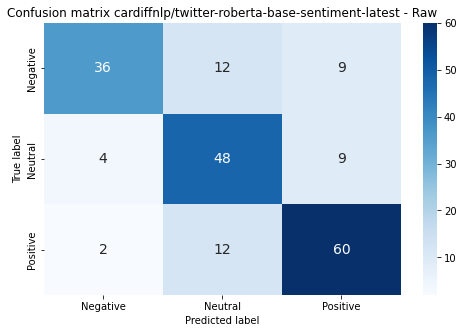

In [34]:
# Create confusion matrices with seaborn

# Raw Confusion matrix
df_cm_raw = pd.DataFrame(cm_raw, columns=label_arrangement, index=label_arrangement)
df_cm_raw.index.name = "True label"
df_cm_raw.columns.name = "Predicted label"
plt.figure(figsize=(8, 5))
plt.title(f"Confusion matrix {model_name} - Raw")
plot_cm_raw = sns.heatmap(
    df_cm_raw, cmap="Blues", annot=True, annot_kws={"size": 14}, fmt="g"
)  # font size

# Log raw confusion matrix to wandb
wandb.log({"Confusion matrix - Raw": wandb.Image(plot_cm_raw)})

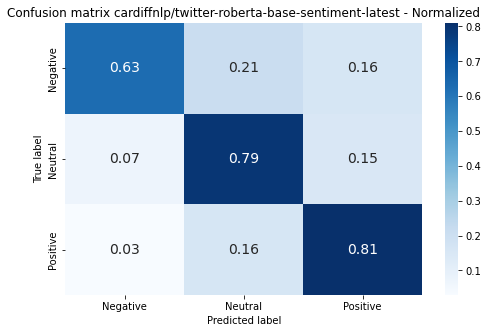

In [35]:
# Normalized Confusion matrix
df_cm_norm = pd.DataFrame(cm_normalized, columns=label_arrangement, index=label_arrangement)
df_cm_norm.index.name = "True label"
df_cm_norm.columns.name = "Predicted label"
plt.figure(figsize=(8, 5))
plt.title(f"Confusion matrix {model_name} - Normalized")
plot_cm_norm = sns.heatmap(
    df_cm_norm, cmap="Blues", annot=True, annot_kws={"size": 14}, fmt="g"
)  # font size

# Log normalized confusion matrix to wandb
wandb.log({"Confusion matrix - Normalized": wandb.Image(plot_cm_norm)})

### Plot confusion matrices for individual classes

In [36]:
mlcf = multilabel_confusion_matrix(y_true_argmax, y_pred_argmax)

In [37]:
# Some weird reshaping because sklearn swaps labels for some reason
# Always needs to be adjusted according to label arrangement
mlcf_positive_class = mlcf[2][[1, 0]][: , [1,0]]
mlcf_negative_class = mlcf[0][[1, 0]][: , [1,0]]
mlcf_neutral_class = mlcf[1][[1, 0]][: , [1,0]]

In [38]:
mlcf_positive_class

array([[ 60,  14],
       [ 18, 100]], dtype=int64)

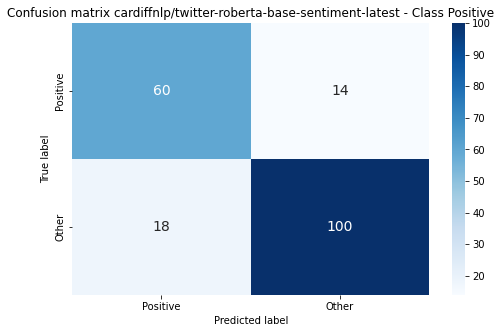

In [39]:
# Confusion matrix for positive class
df_cm_pos = pd.DataFrame(mlcf_positive_class, columns=["Positive", "Other"], index=["Positive", "Other"])
df_cm_pos.index.name = "True label"
df_cm_pos.columns.name = "Predicted label"
plt.figure(figsize=(8, 5))
plt.title(f"Confusion matrix {model_name} - Class Positive")
plot_cm_pos = sns.heatmap(
    df_cm_pos, cmap="Blues", annot=True, annot_kws={"size": 14}, fmt="g"
)  # font size

wandb.log({"Confusion matrix - Class Positive": wandb.Image(plot_cm_pos)})

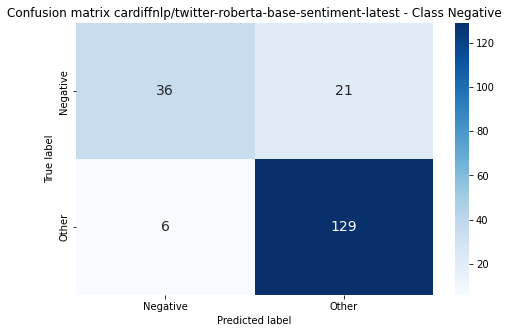

In [40]:
# Confusion matrix for negative class
df_cm_neg = pd.DataFrame(mlcf_negative_class, columns=["Negative", "Other"], index=["Negative", "Other"])
df_cm_neg.index.name = "True label"
df_cm_neg.columns.name = "Predicted label"
plt.figure(figsize=(8, 5))
plt.title(f"Confusion matrix {model_name} - Class Negative")
plot_cm_neg = sns.heatmap(
    df_cm_neg, cmap="Blues", annot=True, annot_kws={"size": 14}, fmt="g"
)  # font size

wandb.log({"Confusion matrix - Class Negative": wandb.Image(plot_cm_neg)})

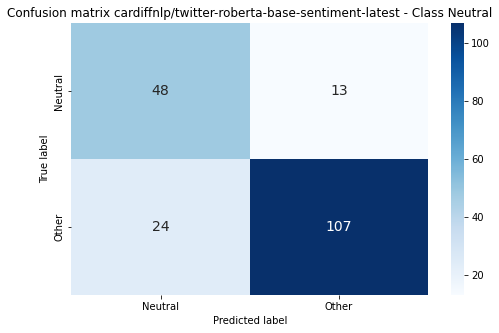

In [41]:
# Confusion matrix for neutral class
df_cm_neutral = pd.DataFrame(mlcf_neutral_class, columns=["Neutral", "Other"], index=["Neutral", "Other"])
df_cm_neutral.index.name = "True label"
df_cm_neutral.columns.name = "Predicted label"
plt.figure(figsize=(8, 5))
plt.title(f"Confusion matrix {model_name} - Class Neutral")
plot_cm_neutral = sns.heatmap(
    df_cm_neutral, cmap="Blues", annot=True, annot_kws={"size": 14}, fmt="g"
)  # font size

wandb.log({"Confusion matrix - Class Neutral": wandb.Image(plot_cm_neutral)})

In [42]:
# Finish run
wandb.finish()

F1-Score Avg,▁
F1-Score Negative,▁
F1-Score Neutral,▁
F1-Score Positive,▁
Max. Validation Accuracy,▁
Min. Validation Loss,▁
Precision Avg,▁
Precision Negative,▁
Precision Neutral,▁
Precision Positive,▁
Recall Avg,▁
